# The importance of Convolutional Neural Networks

## Deep Learning

### This notebook presents some comparison between <b>Fully-connected neural networks</b> and <b>Convolutional Neural Networks</b> on two distinct Classification problems.
### The datasets used in this example are <b>[MNIST](https://en.wikipedia.org/wiki/MNIST_database)</b> and <b>[SVHN](http://ufldl.stanford.edu/housenumbers)</b>.

#### This notebook uses Python version 3.6 or newer.

Let's start by checking the Python version.

In [1]:
import sys

if int(sys.version[0]) < 3 or int(sys.version[2]) < 6:
    assert("Python version 3.6 or newer is required")

We continue by importing the necessary libraries and toolkits.

In [2]:
from IPython.display import clear_output
from math import ceil
from matplotlib.ticker import MaxNLocator
from scipy.io import loadmat
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, log_loss, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras.activations import relu, sigmoid, softmax, tanh
from tensorflow.keras import backend as B
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from time import time
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import requests

%matplotlib inline

random.seed(13)

We define the functions through which we will download and load the SVHN dataset from the remote host.

In [3]:
def update_progress(progress, file_name):
    bar_length = 100
    block = int(progress)
    clear_output(wait = True)
    text = file_name + ' progress: [' + '#' * block + '-' * (bar_length - block) + '] ' + '{:.1f}'.format(progress) + '%'
    print(text)

def download_svhn_train(path):
    url = 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat'
    file_name = url.split("/")[-1]
    
    if not os.path.exists(path + file_name):
        response = requests.get(url, allow_redirects=True, verify=False, stream=True)

        with open(path + file_name, 'wb') as f:
            total_length = response.headers.get('content-length')

            if total_length is None: # no content length header
                f.write(response.content)
            else:
                dl = 0
                total_length = int(total_length)
                for data in response.iter_content(chunk_size=8192):
                    dl += len(data)
                    f.write(data)
                    done = (100. * dl / total_length)
                    update_progress(done, file_name)
        update_progress(100, file_name)
    
    return path + '/' + file_name

def load_svhn_train(path="./train_32x32.mat"):
    # Load data from .mat file
    data_raw = loadmat(path)
    data = np.array(data_raw['X'])
    
    # Transform data into the correct shape and rescale pixel values
    data = np.moveaxis(data, -1, 0) / 255.0
    labels = data_raw['y']
    
    # Split dataset into training and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(data, labels, test_size=7326)
    
    # Labels --> one-hot encodings
    y_train = to_categorical(y_train.reshape([-1, 1]))
    y_valid = to_categorical(y_valid.reshape([-1, 1]))
    
    return X_train, y_train, X_valid, y_valid, data, labels

Let's download the SVHN dataset.

In [4]:
svhn_path = download_svhn_train('./')

Now we define a function through which we will build the fully-connected Neural Network Model.

This function creates a fully connected (dense) neural network for multi-class classification.

We use the <b>categorical_crossentropy</b> loss function and we measure the <b>accuracy</b> of the model.

For the gradient descent optimization, we use <b>Stochastic Gradient Descent</b>.

In [5]:
def build_dense_model(X, y, activation=relu, units=[32], dropout_rate=0.1, learning_rate=0.01):
    """
    Build a Neural Network model based on the data and the parameters
    """
    # Model creation
    model = Sequential()
    
    # Input layer
    model.add(Input(X.shape[1:]))
    
    # Flatten input (transform it into 1D array) for feeding it to the dense layers
    model.add(Flatten())
    
    # Dense (intermediate) layers with dropout
    for i in range(len(units)):
        model.add(Dropout(rate=dropout_rate))
        model.add(Dense(units[i], activation=activation))
    
    # Output layer
    model.add(Dense(y.shape[1], activation=softmax))

    # Model compilation and description
    model.compile(optimizer=SGD(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
    
    return model

Now we define a function through which we will build the Neural Network Model.

This function creates a convolutional neural network for multi-class image classification.

We use the <b>categorical_crossentropy</b> loss function and we measure the <b>accuracy</b> of the model.

For the gradient descent optimization, we use <b>Adam</b>.

In [6]:
def build_cnn_model(X, y, activation=relu, kernel=(3,3), filters=[9,36,49], units=[32], dropout_rate=0.1, learning_rate=0.01):
    """
    Build a Neural Network model based on the data and the parameters
    """
    # Model creation
    model = Sequential()
    
    # Input layer
    model.add(Input(X.shape[1:]))
    
    # Convolutional and max pooling layers
    for i in range(len(filters)):
        model.add(Conv2D(filters[i], kernel, padding='same', activation=activation))
        model.add(MaxPool2D(kernel))
    
    # Flatten data to feed to the dense layers
    model.add(Flatten())
    
    # Dense layers
    for i in range(len(units)):
        model.add(Dropout(rate=dropout_rate))
        model.add(Dense(units[i], activation=activation))
    
    # Output layer
    model.add(Dense(y.shape[1], activation=softmax))

    # Model compilation and description
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
            
    return model

## Experimentation

#### Experiment #1
For the first experiment we are going to use the MNIST dataset.

Let's load the MNIST dataset from Keras into two separate sets:
* A training set
* A validation set

In [7]:
# Load MNIST database
(X_train,y_train), (X_valid,y_valid) = mnist.load_data()

Let's print a randomly selected sample from the training set.

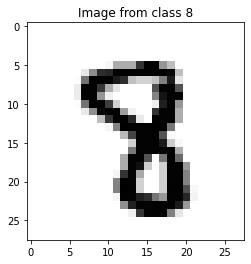

In [8]:
i = random.randint(0, y_train.shape[0]-1)
plt.title(f"Image from class {y_train[i]}")
plt.imshow(X_train[i], cmap='Greys')
plt.show()

Let's calculate the distinct classes as well as the number of samples from the dataset that belong to each class.

In [9]:
# Collect all labels
labels = np.concatenate((y_train, y_valid))

# Find classes from unique labels and their respective data counts
classes, counts = np.unique(labels, return_counts=True)

Let's print a histogram of the counts of the distinct digits in MNIST

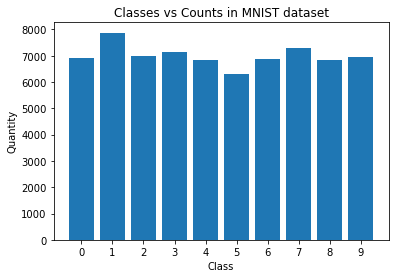

In [10]:
plt.bar(classes, counts)
plt.xticks(classes)
plt.xlabel("Class")
plt.ylabel("Quantity")
plt.title("Classes vs Counts in MNIST dataset")
plt.show()

Let's alter the data so that it fits our problem, by:
* Rescaling the pixel values from [0,255] to [0,1]
* Changing the labels of the samples from single-digit integer numbers to one-hot encoding vectors

In [11]:
# Rescale pixel values
X_train = X_train / 255.0
X_valid = X_valid / 255.0

# Labels --> one-hot encodings
y_train = to_categorical(y_train.reshape([-1, 1]))
y_valid = to_categorical(y_valid.reshape([-1, 1]))

We initialize 5 distinct dictionaries to store the measurements which will be used for the model evaluation and comparisons.

In [12]:
# Initialize lists for data storage
times = {'dense': [], 'conv': []}
accuracies = {'dense': [], 'conv': []}
losses = {'dense': [], 'conv': []}
precisions = {'dense': [], 'conv': []}
recalls = {'dense': [], 'conv': []}
f1s = {'dense': [], 'conv': []}

We are going to use the following set of parameters for the fully-connected model.

In [13]:
# Number of intermediate layers
intermediate_layers = 5

# Number of units per intermediate layer
units = [32] * intermediate_layers

# Dropout rate
dropout_rate = 0.1

# Learning rate
learning_rate = 0.01

# Epochs
epochs = 10

# Epochs for patience
patience = 2

# Activation function
activation = tanh

In [14]:
model = build_dense_model(X_train, y_train, activation, units, learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience, restore_best_weights=True)

t = time()
dense_history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid,y_valid), callbacks=[early_stopping])
t = time() - t

# Evaluate the model
y_val_pred = model.predict(X_valid)
y_val_pred_cat = (np.asarray(y_val_pred)).round()
acc, loss, prec, rec, f1 = accuracy_score(y_valid, y_val_pred_cat), \
                            log_loss(y_valid, y_val_pred_cat), \
                            f1_score(y_valid, y_val_pred_cat, average='macro', zero_division=0), \
                            precision_score(y_valid, y_val_pred_cat, average='macro', zero_division=0), \
                            recall_score(y_valid, y_val_pred_cat, average='macro', zero_division=0)

times['dense'].append(t)
accuracies['dense'].append(acc)
losses['dense'].append(loss)
precisions['dense'].append(prec)
recalls['dense'].append(rec)
f1s['dense'].append(f1)

print('Time (sec):', t)
print('Accuracy:', acc)
print('Log Loss:', loss)
print('Precision:', prec)
print('Recall:', rec)
print('F1 score:', f1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1

Change the dimensions of both training and validation sets so that they are proper for the convolutional layers.

In [15]:
X_train = np.reshape(X_train, X_train.shape+(1,))
X_valid = np.reshape(X_valid, X_valid.shape+(1,))

We are going to use the following set of parameters for the convolutional model.

In [16]:
activation = relu
kernel = (3, 3)
filters = [9, 36, 49]
units = [32]
dropout_rate = 0.1
patience = 2
learning_rate = 0.001
epochs = 10

In [17]:
model = build_cnn_model(X_train, y_train, relu, kernel, filters, units, dropout_rate, learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience, restore_best_weights=True)

t = time()
conv_history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=[early_stopping])
t = time() - t

# Evaluate the model
y_val_pred = model.predict(X_valid)
y_val_pred_cat = (np.asarray(y_val_pred)).round()
acc, loss, prec, rec, f1 = accuracy_score(y_valid, y_val_pred_cat), \
                            log_loss(y_valid, y_val_pred_cat), \
                            f1_score(y_valid, y_val_pred_cat, average='macro', zero_division=0), \
                            precision_score(y_valid, y_val_pred_cat, average='macro', zero_division=0), \
                            recall_score(y_valid, y_val_pred_cat, average='macro', zero_division=0)

times['conv'].append(t)
accuracies['conv'].append(acc)
losses['conv'].append(loss)
precisions['conv'].append(prec)
recalls['conv'].append(rec)
f1s['conv'].append(f1)

print('Time (sec):', t)
print('Accuracy:', acc)
print('Log loss:', loss)
print('Precision:', prec)
print('Recall:', rec)
print('F1 score:', f1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 9)         90        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 9)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 36)          2952      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 36)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 49)          15925     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 49)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 49)               

Let's plot the accuracies and losses to see what we achieved and compare the models.

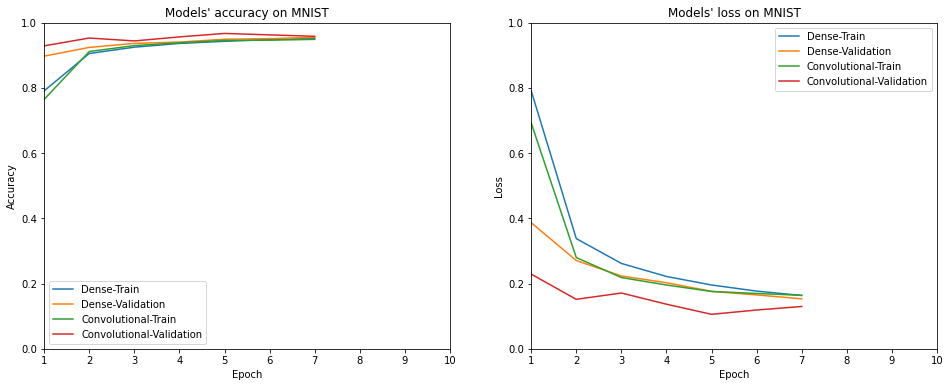

In [18]:
fig = plt.figure(figsize=(16,6))

xr = min(len(dense_history.history['accuracy']), len(conv_history.history['accuracy']))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(range(1,xr+1),dense_history.history['accuracy'][:xr])
plt.plot(range(1,xr+1),dense_history.history['val_accuracy'][:xr])
plt.plot(range(1,xr+1),conv_history.history['accuracy'][:xr])
plt.plot(range(1,xr+1),conv_history.history['val_accuracy'][:xr])
plt.title("Models' accuracy on MNIST")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Dense-Train', 'Dense-Validation', 'Convolutional-Train', 'Convolutional-Validation'], loc='best')
plt.ylim(0., 1.)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

ylim = ceil(max([max(dense_history.history['loss']), max(dense_history.history['val_loss']), max(conv_history.history['loss']), max(conv_history.history['val_loss'])]))

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(1,xr+1),dense_history.history['loss'][:xr])
plt.plot(range(1,xr+1),dense_history.history['val_loss'][:xr])
plt.plot(range(1,xr+1),conv_history.history['loss'][:xr])
plt.plot(range(1,xr+1),conv_history.history['val_loss'][:xr])
plt.title("Models' loss on MNIST")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Dense-Train', 'Dense-Validation', 'Convolutional-Train', 'Convolutional-Validation'], loc='best')
plt.ylim(0., ylim)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

plt.show()
# fig.savefig('./acc-loss-1.png')

Now, we should compare the two models, to see which performs better in total. For the comparison, the following metrics will be used:
* Training time
* Accuracy
* Log loss
* Precision
* Recall
* F1 score

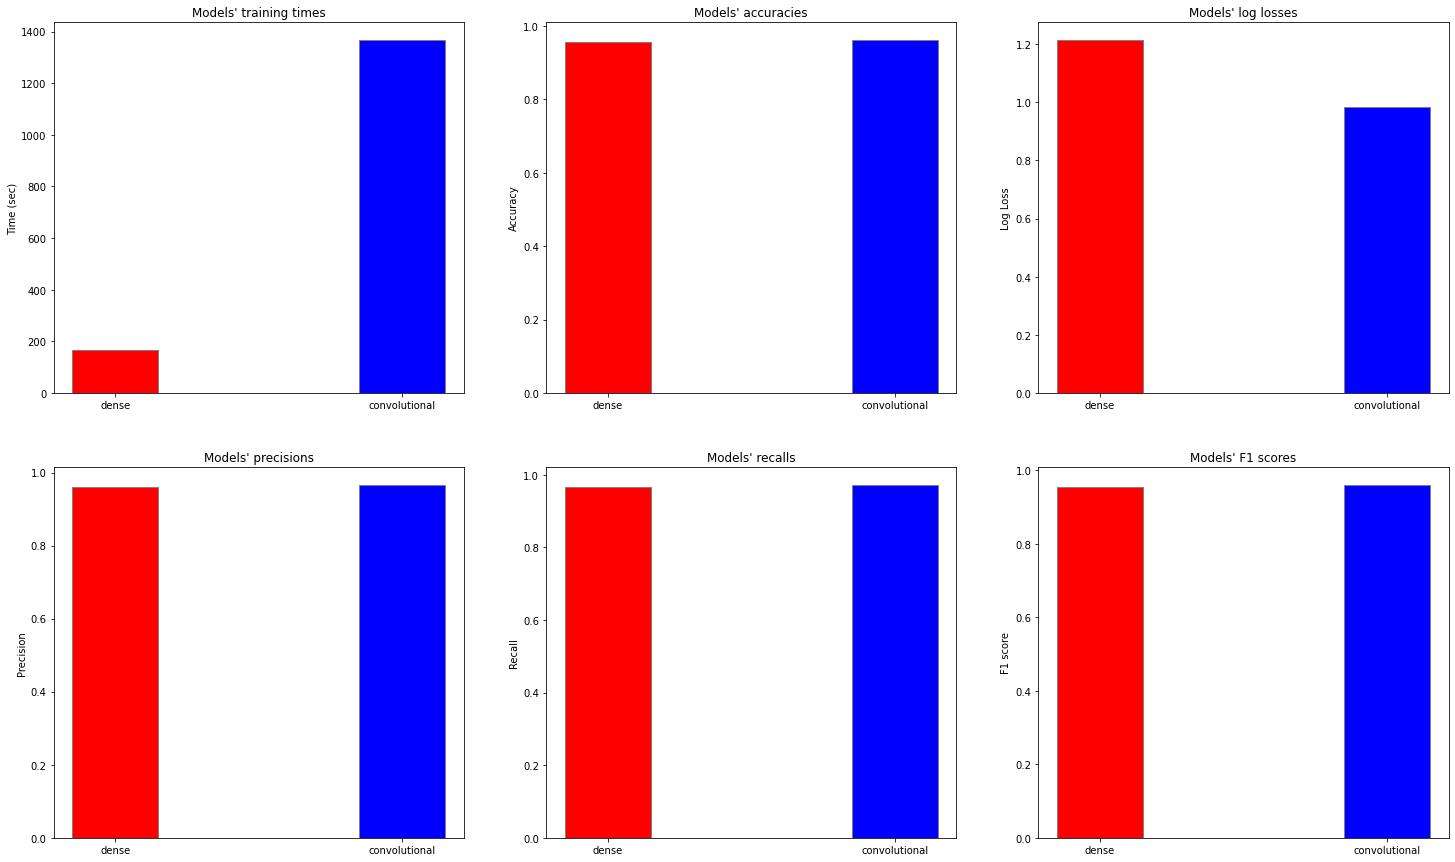

In [19]:
fig = plt.figure(figsize=(25,15))

plt.subplot(2, 3, 1)
plt.bar('dense', times['dense'][0], color='r', width=0.3,
        edgecolor='grey', label='dense')
plt.bar('convolutional', times['conv'][0], color='b', width=0.3,
        edgecolor='grey', label='convolutional')
plt.title("Models' training times")
plt.ylabel('Time (sec)')

plt.subplot(2, 3, 2)
plt.bar('dense', accuracies['dense'][0], color='r', width=0.3,
        edgecolor='grey', label='dense')
plt.bar('convolutional', accuracies['conv'][0], color='b', width=0.3,
        edgecolor='grey', label='convolutional')
plt.title("Models' accuracies")
plt.ylabel('Accuracy')

plt.subplot(2, 3, 3)
plt.bar('dense', losses['dense'][0], color='r', width=0.3,
        edgecolor='grey', label='dense')
plt.bar('convolutional', losses['conv'][0], color='b', width=0.3,
        edgecolor='grey', label='convolutional')
plt.title("Models' log losses")
plt.ylabel('Log Loss')

plt.subplot(2, 3, 4)
plt.bar('dense', precisions['dense'][0], color='r', width=0.3,
        edgecolor='grey', label='dense')
plt.bar('convolutional', precisions['conv'][0], color='b', width=0.3,
        edgecolor='grey', label='convolutional')
plt.title("Models' precisions")
plt.ylabel('Precision')

plt.subplot(2, 3, 5)
plt.bar('dense', recalls['dense'][0], color='r', width=0.3,
        edgecolor='grey', label='dense')
plt.bar('convolutional', recalls['conv'][0], color='b', width=0.3,
        edgecolor='grey', label='convolutional')
plt.title("Models' recalls")
plt.ylabel('Recall')

plt.subplot(2, 3, 6)
plt.bar('dense', f1s['dense'][0], color='r', width=0.3,
        edgecolor='grey', label='dense')
plt.bar('convolutional', f1s['conv'][0], color='b', width=0.3,
        edgecolor='grey', label='convolutional')
plt.title("Models' F1 scores")
plt.ylabel('F1 score')

plt.show()
# fig.savefig(f'./measurements-1.png')

#### Experiment #2
For the second experiment we are going to use the SVHN dataset.

Let's load the SVHN dataset into two separate sets:
* A training set
* A validation set

In [20]:
# Load SVHN dataset
X_train, y_train, X_valid, y_valid, data, labels = load_svhn_train(svhn_path)

Let's calculate the distinct classes as well as the number of samples from the dataset that belong to each class.

In [21]:
# Find classes from unique labels and their respective data counts
classes, counts = np.unique(labels, return_counts=True)

Let's print a randomly selected training sample from the dataset.

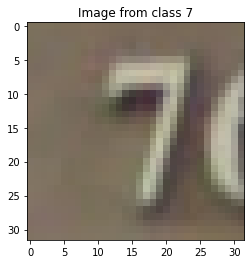

In [22]:
i = random.randint(0, data.shape[0]-1)
plt.title(f"Image from class {labels[i][0] % classes.size}")
plt.imshow(data[i], cmap='Greys')
plt.show()

Let's print a histogram of the counts of the distinct classes in SVHN

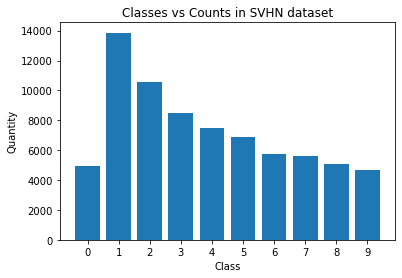

In [23]:
plt.bar(classes % classes.size, counts)
plt.xticks(classes % classes.size)
plt.xlabel("Class")
plt.ylabel("Quantity")
plt.title("Classes vs Counts in SVHN dataset")
plt.show()

We initialize 5 distinct dictionaries to store the measurements which will be used for the model evaluation and comparisons.

In [24]:
# Initialize lists for data storage
times = {'dense': [], 'conv': []}
accuracies = {'dense': [], 'conv': []}
losses = {'dense': [], 'conv': []}
precisions = {'dense': [], 'conv': []}
recalls = {'dense': [], 'conv': []}
f1s = {'dense': [], 'conv': []}

We are going to use the following set of parameters for the fully-connected model.

In [25]:
# Number of intermediate layers
intermediate_layers = 3

# Number of units per intermediate layer
units = [512] * intermediate_layers

# Dropout rate
dropout_rate = 0.1

# Learning rate
learning_rate = 0.01

# Epochs
epochs = 10

# Epochs for patience
patience = 2

# Activation function
activation = tanh

In [26]:
model = build_dense_model(X_train, y_train, activation, units, learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience, restore_best_weights=True)

t = time()
dense_history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid,y_valid), callbacks=[early_stopping])
t = time() - t

# Evaluate the model
y_val_pred = model.predict(X_valid)
y_val_pred_cat = (np.asarray(y_val_pred)).round()
acc, loss, prec, rec, f1 = accuracy_score(y_valid, y_val_pred_cat), \
                            log_loss(y_valid, y_val_pred_cat), \
                            f1_score(y_valid, y_val_pred_cat, average='macro', zero_division=0), \
                            precision_score(y_valid, y_val_pred_cat, average='macro', zero_division=0), \
                            recall_score(y_valid, y_val_pred_cat, average='macro', zero_division=0)

times['dense'].append(t)
accuracies['dense'].append(acc)
losses['dense'].append(loss)
precisions['dense'].append(prec)
recalls['dense'].append(rec)
f1s['dense'].append(f1)

print('Time (sec):', t)
print('Accuracy:', acc)
print('Log Loss:', loss)
print('Precision:', prec)
print('Recall:', rec)
print('F1 score:', f1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 3072)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)              

We are going to use the following set of parameters for the convolutional model.

In [27]:
activation = relu
kernel = (3, 3)
filters = [9, 36, 49]
units = [32]
dropout_rate = 0.1
patience = 2
learning_rate = 0.001
epochs = 10

In [28]:
model = build_cnn_model(X_train, y_train, relu, kernel, filters, units, dropout_rate, learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience, restore_best_weights=True)

t = time()
conv_history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=[early_stopping])
t = time() - t

# Evaluate the model
y_val_pred = model.predict(X_valid)
y_val_pred_cat = (np.asarray(y_val_pred)).round()
acc, loss, prec, rec, f1 = accuracy_score(y_valid, y_val_pred_cat), \
                            log_loss(y_valid, y_val_pred_cat), \
                            f1_score(y_valid, y_val_pred_cat, average='macro', zero_division=0), \
                            precision_score(y_valid, y_val_pred_cat, average='macro', zero_division=0), \
                            recall_score(y_valid, y_val_pred_cat, average='macro', zero_division=0)

times['conv'].append(t)
accuracies['conv'].append(acc)
losses['conv'].append(loss)
precisions['conv'].append(prec)
recalls['conv'].append(rec)
f1s['conv'].append(f1)

print('Time (sec):', t)
print('Accuracy:', acc)
print('Log Loss:', loss)
print('Precision:', prec)
print('Recall:', rec)
print('F1 score:', f1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 9)         252       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 9)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 36)        2952      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 36)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 49)          15925     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 49)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 49)               

Let's plot the accuracies and losses to see what we achieved and compare the models.

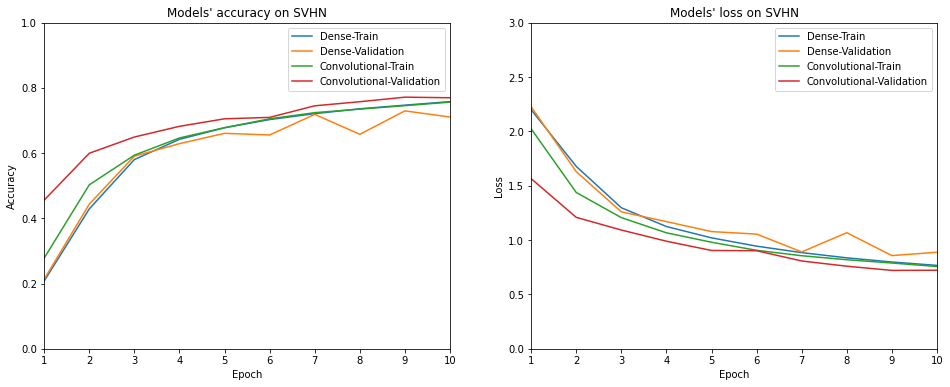

In [29]:
fig = plt.figure(figsize=(16,6))

xr = min(len(dense_history.history['accuracy']), len(conv_history.history['accuracy']))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(range(1,xr+1),dense_history.history['accuracy'][:xr])
plt.plot(range(1,xr+1),dense_history.history['val_accuracy'][:xr])
plt.plot(range(1,xr+1),conv_history.history['accuracy'][:xr])
plt.plot(range(1,xr+1),conv_history.history['val_accuracy'][:xr])
plt.title("Models' accuracy on SVHN")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Dense-Train', 'Dense-Validation', 'Convolutional-Train', 'Convolutional-Validation'], loc='best')
plt.ylim(0., 1.)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

ylim = ceil(max([max(dense_history.history['loss']), max(dense_history.history['val_loss']), max(conv_history.history['loss']), max(conv_history.history['val_loss'])]))

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(1,xr+1),dense_history.history['loss'][:xr])
plt.plot(range(1,xr+1),dense_history.history['val_loss'][:xr])
plt.plot(range(1,xr+1),conv_history.history['loss'][:xr])
plt.plot(range(1,xr+1),conv_history.history['val_loss'][:xr])
plt.title("Models' loss on SVHN")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Dense-Train', 'Dense-Validation', 'Convolutional-Train', 'Convolutional-Validation'], loc='best')
plt.ylim(0., ylim)
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))

plt.show()
# fig.savefig('./acc-loss-2.png')

Now, we should compare the two models, to see which performs better in total. For the comparison, the following metrics will be used:
* Training time
* Accuracy
* Log loss
* Precision
* Recall
* F1 score

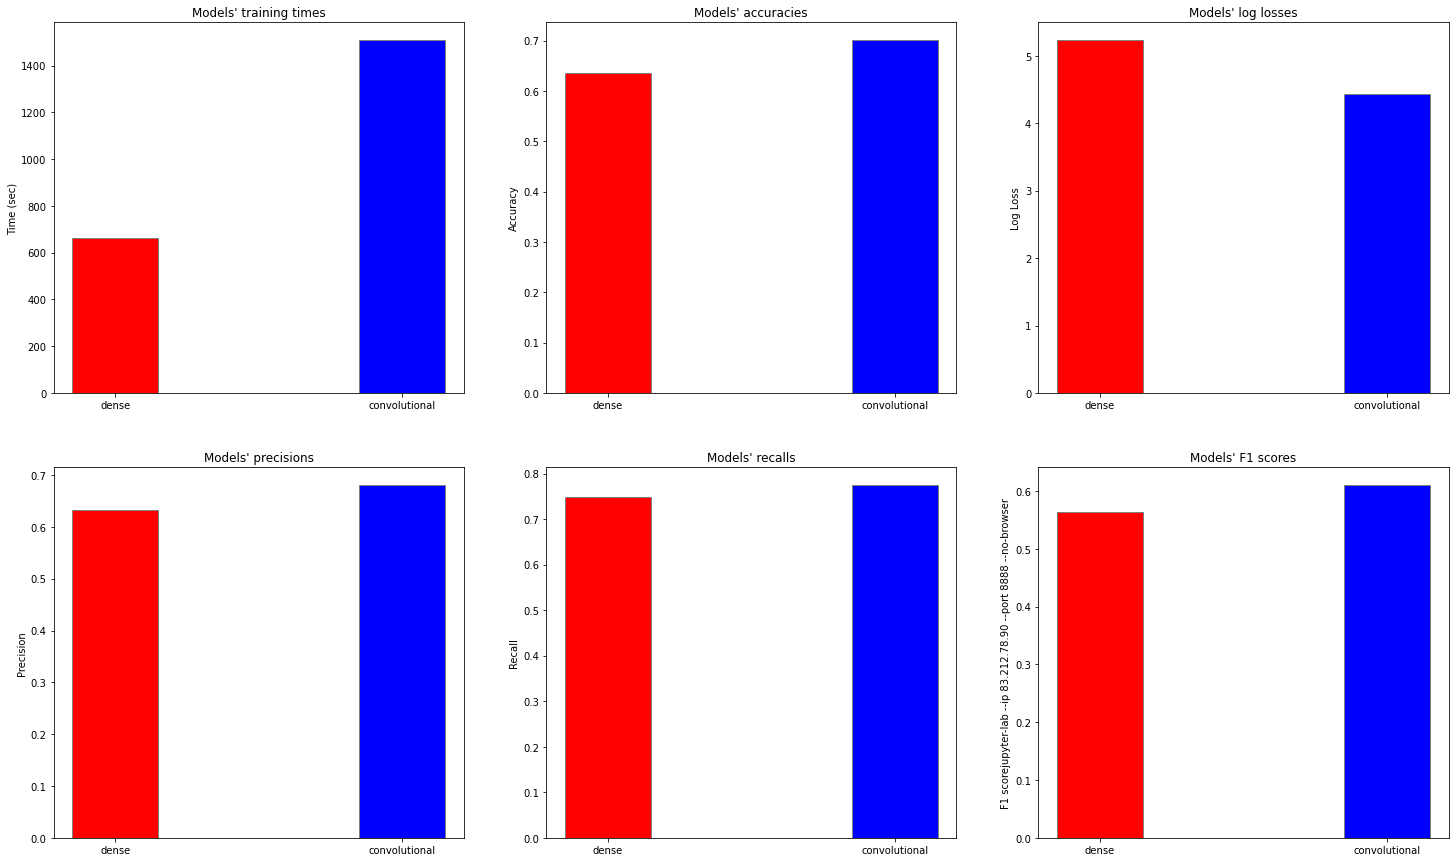

In [30]:
fig = plt.figure(figsize=(25,15))

plt.subplot(2, 3, 1)
plt.bar('dense', times['dense'][0], color='r', width=0.3,
        edgecolor='grey', label='dense')
plt.bar('convolutional', times['conv'][0], color='b', width=0.3,
        edgecolor='grey', label='convolutional')
plt.title("Models' training times")
plt.ylabel('Time (sec)')

plt.subplot(2, 3, 2)
plt.bar('dense', accuracies['dense'][0], color='r', width=0.3,
        edgecolor='grey', label='dense')
plt.bar('convolutional', accuracies['conv'][0], color='b', width=0.3,
        edgecolor='grey', label='convolutional')
plt.title("Models' accuracies")
plt.ylabel('Accuracy')

plt.subplot(2, 3, 3)
plt.bar('dense', losses['dense'][0], color='r', width=0.3,
        edgecolor='grey', label='dense')
plt.bar('convolutional', losses['conv'][0], color='b', width=0.3,
        edgecolor='grey', label='convolutional')
plt.title("Models' log losses")
plt.ylabel('Log Loss')

plt.subplot(2, 3, 4)
plt.bar('dense', precisions['dense'][0], color='r', width=0.3,
        edgecolor='grey', label='dense')
plt.bar('convolutional', precisions['conv'][0], color='b', width=0.3,
        edgecolor='grey', label='convolutional')
plt.title("Models' precisions")
plt.ylabel('Precision')

plt.subplot(2, 3, 5)
plt.bar('dense', recalls['dense'][0], color='r', width=0.3,
        edgecolor='grey', label='dense')
plt.bar('convolutional', recalls['conv'][0], color='b', width=0.3,
        edgecolor='grey', label='convolutional')
plt.title("Models' recalls")
plt.ylabel('Recall')

plt.subplot(2, 3, 6)
plt.bar('dense', f1s['dense'][0], color='r', width=0.3,
        edgecolor='grey', label='dense')
plt.bar('convolutional', f1s['conv'][0], color='b', width=0.3,
        edgecolor='grey', label='convolutional')
plt.title("Models' F1 scores")
plt.ylabel('F1 scorejupyter-lab --ip 83.212.78.90 --port 8888 --no-browser')

plt.show()
# fig.savefig('./measurements-2.png')

### Conclusions

We can see that a very basic (not fine-tuned) convolutional neural network model always performs better than a basic (not fine-tuned) fully-connected neural network model, while needing fewer training epochs to do so.

Surely, fine-tuning the hyperparameters of the model (such as #layers, #units per layer, learning rate, etc.) can result in greater accuracy and lower loss for both the fully-connected network and the convolutional neural network.

However, since the convolutional neural networks were inspired by the human vision, we always expect getting better results from their use when it comes to images.

Finally, the convolutional models require significantly more time for training. Because of this, tasdfhe use of a GPU is always recommended.